<h1> Open-Loop Coherent Compressed Sensor (OL-CCS) </h1>

Code by: M. D. Sudeera H. Gunathilaka 

Github: https://github.com/SuhiG

<h1> 1) Description </h1>

<h1> Introduction & Model </h1>
Compressed sensing (CS) is a method of reconstructing a high-dimensional signal or image based on highly downsampled measurements.

The Coherent Compressed Sensor (CCS) is designed to solve the problem of $l_0$-Regularised Compressed Sensing, which is a combinatorial optimisation problem. The problem Hamiltonian can be stated as follows.

$$ H = \sum_{r<r'}^{N}\sum_{k = 1}^{M} A_{r}^{k}A_{r'}^{k}R_{r}R_{r'}\sigma_{r}\sigma_{r'} - \sum_{r=1}^{N}\sum_{k =1}^{M} y^{k}A_{r}^{k}R_{r}\sigma_{r} + {\lambda} \sum_{r = 1}^{N} \sigma_r .$$

The above equation shows an observed signal $y \in \mathbb{R}^M$ and an observation matrix $A \in \mathbb{R}^{M\times N}$. The term $R \in \mathbb{R}^N$ and $\sigma \in \left\{{0,1}\right\}^N$ correspond to the source signal and support vector, respectively.
In this case, the quadratic optimisation part of the problem (signal - $R_{r}$) is done by using the Classical Digital Processor (CDP) while the combinatorial optimisation part of the problem (support - $\sigma_{r}$) is performed by the CIM in alternate steps.

For the CIM, the injection and local fields can be specified as follows.

$$    \left(\dfrac{dc_{r}}{dt}\right)_{inj,r} = \left(|h_r| - \eta\right). $$

$$h_{r} = -{\sum_{r' = 1 (\neq r)}^{N}\sum_{k = 1}^{M}} A_r^k A_{r'}^k R_{r'}H(c_{r'}) + \sum_{k=1}^M A_{r}^k y^{k} . $$

$H(c_r)$ is the binarised in-phase amplitude by the Heaviside step function. $\eta$ is the threshold which is related to the $l_0$-regularisation parameter $\lambda$ by $\eta = \sqrt{2\lambda}$ according to the Maxwell rule.
Open-Loop CCS is composed of the following stochastic differential equations.

$$
        \frac{d}{dt}c_r = \left[-1 + p - {\left(c_r^2 + s_r^2\right)} \right]c_r + \widetilde{K}\left(\dfrac{dc_{r}}{dt}\right)_{inj,r} + {g^2}\sqrt{\left(c_r^2 + s_r^2\right) + \frac{1}{2}} W_{r,1},$$



$$\frac{d}{dt}s_r = \left[-1 - p - {\left(c_r^2 + s_r^2\right)}\right]s_r + {g^2}\sqrt{\left(c_r^2 + s_r^2\right) + \frac{1}{2}} W_{r,2} .
$$

Here, in-phase and quadrature-phase normalised amplitudes are represented as $c_r$ and $s_r$ respectively. $p$ is the normalised pump rate. $W_{r,1}$ and $W_{r,2}$ are independent real Gaussian noise processes. The term ${g^2}$ indicates the saturation parameter while $\widetilde{K}$ indicates the normalised feedback strength. 

In the CDP, we solve the following system of equations using the Jacobi method.

$$ R_{r}\sum_{k = 1}^{M} \left(A_{r}^{k}\right)^2 = \sigma_{r}\mathbb{H}_{r}, $$


$$ \mathbb{H}_{r} = -\sum_{r' = 1 (\neq r)}^{N}\sum_{k = 1}^{M} A_{r}^{k}A_{r'}^{k}R_{r'}\sigma_{r'} + \sum_{k =1}^{M} A_{r}^{k}y^{k} .$$


<h1> Benchmark </h1>

OL-CCS performance is evaluated for randomly generated CS problem instances and Magnetic Resonance Imaging (MRI) of a brain. The performance accuracy is evaluated by calculating the Root-Mean-Squared-Error (RMSE) as $$ \sqrt{\dfrac{1}{N} \sum_{r=1}^N \left(R_r\sigma_r - x_r\xi_r\right)^2}, $$

where $R_r$ and $\sigma_r$ is the estimated signal and support from OL-CCS and $x_r$ and $\xi_r$ is the correct signal and support for the CS problem instance. Furthermore, we compare the performance of OL-CCS on the MRI data simulations to that of the $l_1$-Regularised method called LASSO, which is considered as one of the popular $l_1$-Regularised methods.

<h1> Pseudo-code </h1>

    FOR rep IN 0:reps
        FOR t IN 0:tmax
            Set h_i to J*(rCDP*sigCIM) + hz                      #Matrix-Vector multiplication
            Set c to c + (-(1 - p + c**2 + s**2)*c + JJ * (abs(h_i) - eta) + g * sqrt(c**2 + s**2 + 0.5) * w1)*dt
            Set s to s + (-(1 + p + c**2 + s**2)*s + g * sqrt(c**2 + s**2 + 0.5) * w2)*dt
            Set sigCIM to ((c/abs(c))+1)/2
        END FOR
        FOR tt IN 0:ttmax
            Set hCDP to J*(rCDP*sigCIM) + hz                     #Matrix-Vector multiplication
            Set rCDP to rCDP + (-rCDP + hCDP)*dt1
        END FOR
    END FOR

<h1>References </h1>

[1]. T. Aonishi, K. Mimura, M. Okada, and Y. Yamamoto, “L0 regularization based compressed sensing with quantum–classical hybrid approach,” Quantum Science and Technology 7, 035013 (2022)

[2]. M. D. S. H. Gunathilaka, S. Kako, Y. Inui, K. Mimura, M. Okada, Y. Yamamoto, and T. Aonishi, “Effective implementation of L0-regularised compressed sensing with chaotic-amplitude-controlled coherent ising machines,” Scientific Reports 13, 16140 (2023).

<h1> 2) OL-CCS on Random CS problem instances </h1>

In [1]:
import torch
import time
import numpy as np
import matplotlib.pyplot as plt
import math
from statistics import mean
from numpy import genfromtxt

In [2]:
N = 2000 # System size (N)
M = 1200 # Compressed size (N*compression ratio - This case 2000*0.6=1200)
K = 1
sparseness = 0.2 # Ratio of non-zero elemnts in the initial vector
probs = 10 # Number of problems
rmseArr = []

stt = time.time()
for pp in range(probs):
    
    torch.manual_seed(pp)
    AA = torch.normal(mean=0, std=1, size=(M,N), dtype=torch.float64) # Observation matix
    AA = AA/math.sqrt(M)
    signal = torch.normal(mean=0, std=1, size=(N,), dtype=torch.float64) # Signal (Continuous)
    support = torch.ones(N, dtype=torch.float64) # Support (Binary)

    # Creating a sparse Support according to the sparseness ratio
    for i in range(N):
        if (i <= (sparseness * N)):
            support[i] = 1
        else:
            support[i] = 0

    y = torch.matmul(AA, signal * support) # Observation signal
    A_norm = torch.zeros(N, dtype=torch.float64)

    # Norm of the observation matrix
    for i in range(N):
        A_norm[i] = 0
        for j in range(M):
            A_norm[i] += AA[j][i] * AA[j][i]
        A_norm[i] = torch.sqrt(A_norm[i])

    J = torch.zeros((N,N), dtype=torch.float64)
    hz = torch.zeros(N, dtype=torch.float64)


    J = torch.matmul((AA/A_norm).T, AA/A_norm) # Coupling matrix
    J.fill_diagonal_(0)
    J = -J
    hz = torch.matmul((AA/A_norm).T, y) # Zeeman term

    ## CIM

    eta_int = 0.6 # Starting L0-Regularisation parameter
    eta_end = 0.01 # Starting L0-Regularisation parameter
    REP = 50 # Number of alternating minimisation processes
    JJ = 0.25 # Feedback strength
    Tmax = 5 # Max-time for CIM
    dt = 0.1 # Time-step for CIM
    dt1 = 0.1 # Time-step for CDP
    RTmax = 10 # Max-time for CDP
    g = 1e-7 # Saturation parameter 
    Pmax = 1.5 # Max Pump rate

    timeStepArr = torch.arange(0, Tmax/0.1+1, 1)
    pump = torch.zeros(len(timeStepArr))
    p = torch.pow(timeStepArr * (0.1/Tmax),2)*Pmax # Pump rate schedulling

    sigCIM = torch.zeros(N, dtype=torch.float64)
    rCDP = torch.zeros(N, dtype=torch.float64)

    for ll in range(REP+1):
        eta = max(eta_int * (1 - (ll/REP)), eta_end) # L0-Regularisation parameter schedulling

        sigCIM = torch.zeros(N, dtype=torch.float64)
        c = torch.zeros(N, dtype=torch.float64)
        s = torch.zeros(N, dtype=torch.float64)
        dc = torch.zeros(N, dtype=torch.float64)
        ds = torch.zeros(N, dtype=torch.float64)            

        for l in range(len(timeStepArr)):

            # Injection field Calculation
            out = rCDP*sigCIM
            Zeeman = hz
            h_i = torch.matmul(J,out) + Zeeman

            # OL-CCS SDEs 
            w1 = torch.normal(mean=0, std=1, size=(N,), dtype=torch.float64)
            w2 = torch.normal(mean=0, std=1, size=(N,), dtype=torch.float64)
            dc = -(1 - pump[l] + torch.pow(c,2) + torch.pow(s,2))*c + JJ * (torch.abs(h_i) - eta) + g * torch.sqrt(torch.pow(c,2) + torch.pow(s,2) + 0.5) * w1
            ds = -(1 + pump[l] + torch.pow(c,2) + torch.pow(s,2))*s + g * torch.sqrt(torch.pow(c,2) + torch.pow(s,2) + 0.5) * w2
            c = c + dc * dt
            s = s + ds * dt
            sigCIM = ((torch.div(c, torch.abs(c))+1)/2) # Support estimation
        
        # Jacobi method for Signal optimisation
        for rr in np.arange(0.0,RTmax/dt1,1.0):

            hCDP = torch.matmul(J,(rCDP*sigCIM)) + hz
            rCDP = rCDP + (-rCDP + hCDP)*dt1

    # Evaluation by Root-Mean-Squared-Error (RMSE)
    rmse = torch.sqrt(1/N * torch.sum(torch.pow(torch.sub((sigCIM * rCDP)/A_norm, signal * support),2)))
    rmseArr.append(rmse.detach().cpu().numpy())
    print("Problem = "+ "{:.0f}".format(pp) +" | "+ " RMSE = "+ "{:.4f}".format(rmse))

print(time.time() - stt, "s")
print("==> N = "+ str(N) + ", M = "+ str(M) + " | Problems = "+ "{:.0f}".format(probs) +" | "+ " average RMSE = "+ "{:.4f}".format(sum(rmseArr)/probs))


Problem = 0 |  RMSE = 0.0004
Problem = 1 |  RMSE = 0.0006
Problem = 2 |  RMSE = 0.0005
Problem = 3 |  RMSE = 0.0004
Problem = 4 |  RMSE = 0.0006
Problem = 5 |  RMSE = 0.0007
Problem = 6 |  RMSE = 0.0006
Problem = 7 |  RMSE = 0.0007
Problem = 8 |  RMSE = 0.0002
Problem = 9 |  RMSE = 0.0006
261.84485912323 s
==> N = 2000, M = 1200 | Problems = 10 |  average RMSE = 0.0005


<h1> 3) OL-CCS on Sparse-MRI problem instances </h1>

In [3]:
# Data import
HerIMP = genfromtxt('Her6400456.csv', delimiter=',')
x0initIMP = genfromtxt('x0_init_numpy6400456.csv', delimiter=',')
hzIMP = genfromtxt('hz6400456.csv', delimiter=',')
JJIMP = genfromtxt('JJ6400456.csv', delimiter=',')
rIMP = genfromtxt('r6400456.csv', delimiter=',')
tor_AD_invIMP = genfromtxt('AD_inv_6400456.csv', delimiter=',')    

eta = 0.0110 |  OL = 0.0210 |  LASSO = 0.0349
53.197179079055786 s


Text(0.5, 1.0, 'OL-CCS | RMSE = 0.0210')

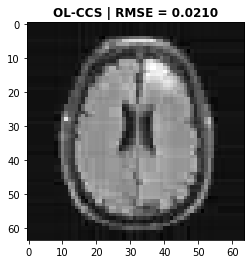

In [4]:
alpha = 0.4 # compression ratio
px = 64 # 1D pixels
N = px*px # 2D pixels (System size)
M = np.intc(np.floor(alpha*N)) # compressed resulting pixels
K = 1

stt = time.time()
        
# HAAR wavelet basis matrix
Her = torch.tensor(np.array((HerIMP)), dtype=torch.float64)

# Initial Sparse MRI image vector
x0init = torch.tensor(np.array((x0initIMP)), dtype=torch.float64)

# Zeeman term
hz = torch.tensor(np.array((hzIMP)), dtype=torch.float64) 

# Coupling matrix
J = torch.reshape(torch.tensor(np.array((JJIMP)), dtype=torch.float64),[N,N]) 

# LASSO results
r = torch.tensor(np.array((rIMP)), dtype=torch.float64)

# Inverse of diagonal entries of the COupling matrix for normalisation in the CDP
tor_AD_inv = torch.tensor(np.array((tor_AD_invIMP)), dtype=torch.float64)

dt = 0.1 # Time-step for CIM
Tmax = 5. # Max-time for CIM
JJ = 0.25 # Injection strength
REPs = 31 # Number of alternating minimisation processes
dt1 = 0.1 # Time for CDP
g = 1e-7 # Saturation parameter 
Pmax = 1.5 # Max Pump rate
RTmax = 1000 # Max-Time iterations for CDP

torch.manual_seed(0)

# Caculating LASSO RMSE
rmseLASSO = torch.sqrt((torch.subtract(x0init, torch.reshape(torch.matmul(torch.matmul(torch.transpose(Her,0,1),torch.reshape(r,(px, px))), Her),(-1,)))**2).mean(axis=0))

timeStepArr = torch.arange(0, Tmax/0.1+1, 1)
pump = torch.zeros(len(timeStepArr))
p = torch.pow(timeStepArr * (0.1/Tmax),2)*Pmax # Pump rate schedulling

sigCIM = torch.zeros(N, dtype=torch.float64)
rCDP = torch.zeros(N, dtype=torch.float64)
rCDP = r

for ll in range(REPs):
    eta = 0.0110 # L0-Regularisation parameter

    sigCIM = torch.zeros(N, dtype=torch.float64)
    c = torch.zeros(N, dtype=torch.float64)
    s = torch.zeros(N, dtype=torch.float64)
    dc = torch.zeros(N, dtype=torch.float64)
    ds = torch.zeros(N, dtype=torch.float64)            

    for l in range(len(timeStepArr)):

        # Injection field
        out = rCDP*sigCIM
        Zeeman = hz
        h_i = torch.matmul(J,out) + Zeeman

        # OL-CCS SDEs 
        w1 = torch.normal(mean=0, std=1, size=(N,), dtype=torch.float64)
        w2 = torch.normal(mean=0, std=1, size=(N,), dtype=torch.float64)
        dc = -(1 - pump[l] + torch.pow(c,2) + torch.pow(s,2))*c + JJ * (torch.abs(h_i) - eta) + g * torch.sqrt(torch.pow(c,2) + torch.pow(s,2) + 0.5) * w1
        ds = -(1 + pump[l] + torch.pow(c,2) + torch.pow(s,2))*s + g * torch.sqrt(torch.pow(c,2) + torch.pow(s,2) + 0.5) * w2
        c = c + dc * dt
        s = s + ds * dt
        sigCIM = ((torch.div(c, torch.abs(c))+1)/2) # Support estimation

    # Jacobi method for Signal optimisation
    for rr in np.arange(0.0,RTmax,1.0):

        hCDP = torch.matmul(J,(rCDP*sigCIM)) + hz
        rCDP = rCDP + (-rCDP + tor_AD_inv*hCDP)*dt1

# Evaluation by Root-Mean-Squared-Error (RMSE)
rmseOLCCS = torch.sqrt((torch.subtract(x0init, torch.reshape(torch.matmul(torch.matmul(torch.transpose(Her,0,1),torch.reshape(torch.multiply(sigCIM,rCDP),(px, px))), Her),(-1,)))**2).mean(axis=0))
print("eta = "+ "{:.4f}".format(eta) +" | "+ " OL = "+ "{:.4f}".format(rmseOLCCS) +" | "+" LASSO = "+ "{:.4f}".format(rmseLASSO))   
    
print(time.time() - stt, "s")

# Image reconstruction
XX = torch.matmul(torch.matmul(torch.transpose(Her,0,1),torch.reshape(torch.multiply(sigCIM,rCDP),(px, px))), Her)
plt.rcParams.update({'text.color' : "black",'axes.labelcolor' : "black"})
plt.imshow(XX, cmap = plt.cm.gray) 
plt.title("OL-CCS | RMSE = "+ "{:.4f}".format(rmseOLCCS), fontweight ="bold")